In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from numba import njit, prange
from tqdm import tqdm
from scipy.optimize import curve_fit

In [2]:
@njit(parallel=True)
def run_ucb(bandit, runs, timesteps, c=2):
	regret = np.zeros((runs, timesteps))
	best_arm_selected_percent = np.zeros((runs, timesteps))
	err = np.zeros((runs, timesteps))
	for run in prange(runs):
		Q = np.zeros(bandit.shape)
		N = np.zeros(bandit.shape)
		optimal_action_picked = 0
		for t in range(timesteps):
			action = np.argmax(Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5)))
			reward = np.random.normal(bandit[action], 1)
			N[action] += 1
			Q[action] += (reward - Q[action]) / N[action]
			regret[run, t] = np.max(bandit) - bandit[action]
			# error = estimated best arm mean - true best arm mean
			err[run, t] = np.abs(Q[np.argmax(bandit)] - np.max(bandit))
			if regret[run, t] == 0:
				optimal_action_picked += 1
				best_arm_selected_percent[run, t] = optimal_action_picked / (t + 1)

	return regret, err, best_arm_selected_percent

def tvd(mu_1, sigma_1, mu_2, sigma_2):
	'''
	calculate total variation distance given the means and standard deviations
	of two normal distributions
	'''
	x = np.linspace(min(mu_1 - 3 * sigma_1, mu_2 - 3 * sigma_2), max(mu_1 + 3 * sigma_1, mu_2 + 3 * sigma_2), 1000)
	pdf_1 = stats.norm.pdf(x, mu_1, sigma_1)
	pdf_2 = stats.norm.pdf(x, mu_2, sigma_2)
	return 0.5 * np.trapz(np.abs(pdf_1 - pdf_2), x)

def bandit_difficulties(bandits):
	difficulties = np.zeros(len(bandits))
	NUM_BANDITS, NUM_ARMS = bandits.shape
	for idx, bandit in enumerate(bandits):
		best_arm = np.max(bandit)
		second_best_arm = np.sort(bandit)[-2]
		difficulties[idx] = tvd(best_arm, 1, second_best_arm, 1)
		# for arm in bandit:
		# 	difficulties[idx] += tvd(arm, 1, best_arm, 1)
		# difficulties[idx] /= (NUM_ARMS)
	return difficulties


def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

In [3]:
bandits = np.array([
	[1, 2, 5],
	[1, 4, 5],
])

print(bandits)
print(bandit_difficulties(bandits))

runs = 100_000
timesteps = 500

colors = ['tab:red', 'tab:purple']

regrets = []
errors = []
percent_optimals = []
vert_lines = np.zeros(len(bandits))
asymptotes = np.zeros(len(bandits))

for bandit_idx, bandit in enumerate(bandits):
	regret, err, percent_optimal = run_ucb(bandit, runs, timesteps)
	regret = np.mean(np.cumsum(regret, axis=1), axis=0)
	err = np.mean(err, axis=0)
	percent_optimal = np.mean(percent_optimal, axis=0)
	# np.save(f'data/data/ucb_{bandit}_regret.npy', regret)
	# np.save(f'data/data/ucb_{bandit}_percent.npy', percent_optimal)
	# regret = np.load(f'data/data/ucb_{bandit}_regret.npy')
	# percent_optimal = np.load(f'data/data/ucb_{bandit}_percent.npy')
	# plt.plot(err, label=rf'$\nu_{bandit_idx+1}$', color=colors[bandit_idx])
	regrets.append(regret)
	errors.append(err)
	percent_optimals.append(percent_optimal)

[[1 2 5]
 [1 4 5]]
[0.86503692 0.38160736]


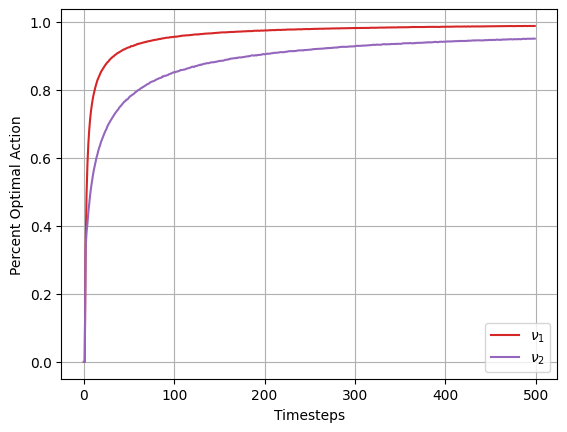

In [4]:
for bandit_idx, bandit in enumerate(bandits):
	plt.plot(percent_optimals[bandit_idx], label=rf'$\nu_{bandit_idx+1}$', color=colors[bandit_idx])

plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Percent Optimal Action')
plt.title('')
plt.legend()
plt.savefig(f'data/img/pdf/bandit_difficulty_ucb_percent.pdf', format='pdf')
plt.show()

[0.06379955 0.06729897]
[146. 154.]


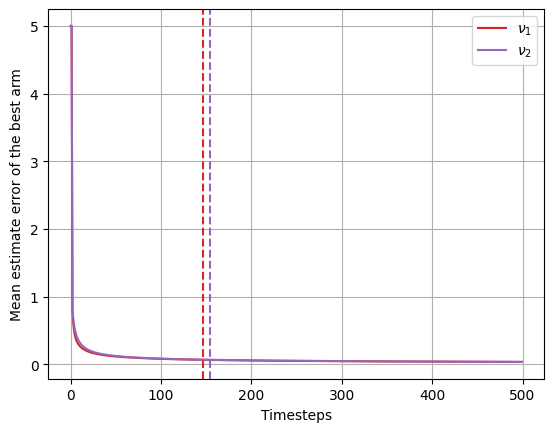

In [5]:
for bandit_idx, bandit in enumerate(bandits):
	popt, pcov = curve_fit(exp_decay, np.arange(len(err)), errors[bandit_idx], p0=(1, 1e-2, 1), maxfev=10000)
	asymptotes[bandit_idx] = popt[2]

for bandit_idx, bandit in enumerate(bandits):
	vert_lines[bandit_idx] = np.argmax(np.abs(errors[bandit_idx] - np.min(asymptotes)) < 0.05 * np.min(asymptotes))
	plt.plot(errors[bandit_idx], label=rf'$\nu_{bandit_idx+1}$', color=colors[bandit_idx])
	plt.axvline(vert_lines[bandit_idx], color=colors[bandit_idx], linestyle='--')

print(asymptotes)
print(vert_lines)

plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Mean estimate error of the best arm')
plt.title('')
plt.legend()
plt.savefig(f'data/img/pdf/bandit_difficulty_ucb_err.pdf', format='pdf')
plt.show()